<a href="https://colab.research.google.com/github/SophieShin/NLP_22_Fall/blob/main/%5BSSH%5Dlab07_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 - AG_NEWS Classification using LSTM
Connect to GPU for this lab (otherwise it will take 10+ mins for training)


In [ ]:
# Install torchdata and restart runtime
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 29.7 MB/s 
     |████████████████████████████████| 140 kB 68.7 MB/s 
     |████████████████████████████████| 127 kB 73.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Load Train and Test Sets

In [ ]:
import torch
import torchtext

from torch.utils.data import DataLoader

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

### Tokenise and Build Vocab

In [ ]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Q1. Use torchtext's "basic english" tokeniser
tokenizer = get_tokenizer("basic_english")

# Q2. Build vocab using build_vocab_from_iterator with out of vocab words given '<UNK>'
train_iter = iter(train_dataset)

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"]) # 이거까지 해줘야 됨. 안해주면 unknown할당이 안됨


### Convert sample text to a list of tokens and then a list of indexes

In [ ]:
tokens = tokenizer("Hello how are you?, Welcome to Deep Learning 2 at SKKU!")
indexes = vocab(tokens)

print(tokens)
print(indexes)

['hello', 'how', 'are', 'you', '?', ',', 'welcome', 'to', 'deep', 'learning', '2', 'at', 'skku', '!']
[12544, 357, 42, 165, 80, 3, 3314, 4, 2161, 4699, 120, 20, 0, 764]


### Data Loaders and Collate Functions

In [ ]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 25

def collate_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] # Tokenize and map tokens to indexes
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 # Subtract 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=collate_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=collate_batch)


In [ ]:
train_dataset[0:2]

[(3,
  "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')]

In [ ]:
list(zip(*train_dataset[0:2]))

[(3, 3),
 ("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')]

In [ ]:
Y, X = list(zip(*train_dataset[0:2]))
print(Y, len(Y))
print(X, len(X))

(3, 3) 2
("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.') 2


### Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### NN class

In [ ]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 75
n_layers=1

class LSTMClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim).to(device) # randn
        cell = torch.randn(n_layers, len(X_batch), hidden_dim).to(device)
        output, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
        return self.linear(output[:,-1]) # just want the last time step hidden state

        # innit_hidden

### Create the NN class instance

In [ ]:
model = LSTMClass()
model

LSTMClass(
  (embedding_layer): Embedding(95811, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=4, bias=True)
)

### Inspect the model's layers

In [ ]:
for layer in model.children(): ## cell/hidden, input 자체도
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(95811, 50)
Parameters : 
torch.Size([95811, 50])

Layer : LSTM(50, 75, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=4, bias=True)
Parameters : 
torch.Size([4, 75])
torch.Size([4])



### Utilities for Training

In [ ]:
from tqdm import tqdm # progress bar
from sklearn.metrics import accuracy_score
import gc

def calculate_loss_acc(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_real, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_real.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_real = torch.cat(Y_real)
        Y_preds = torch.cat(Y_preds)

        print(f"Valid Loss : {torch.tensor(losses).mean():.3f}")
        print(f"Valid Acc  : {accuracy_score(Y_real.cpu().detach().numpy(), Y_preds.cpu().detach().numpy()):.3f}")


def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X).to(device)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())
            loss= loss.to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch\t   : {i}")
        print(f"Train Loss : {torch.tensor(losses).mean():.3f}")
        calculate_loss_acc(model, loss_fn, val_loader)

### Training
- Takes < 1.5 mins on GPU
- Takes 11.5 mins on CPU

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

# Q3. Put model on device before intialising the optimiser
model= model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:04<00:00, 24.14it/s]


Epoch	   : 1
Train Loss : 0.006
Valid Loss : 0.946
Valid Acc  : 0.875


100%|██████████| 118/118 [00:04<00:00, 23.70it/s]


Epoch	   : 2
Train Loss : 0.005
Valid Loss : 0.916
Valid Acc  : 0.876


100%|██████████| 118/118 [00:04<00:00, 24.35it/s]


Epoch	   : 3
Train Loss : 0.004
Valid Loss : 0.937
Valid Acc  : 0.878


100%|██████████| 118/118 [00:05<00:00, 23.45it/s]


Epoch	   : 4
Train Loss : 0.003
Valid Loss : 0.916
Valid Acc  : 0.875


100%|██████████| 118/118 [00:05<00:00, 23.17it/s]


Epoch	   : 5
Train Loss : 0.005
Valid Loss : 1.013
Valid Acc  : 0.871


100%|██████████| 118/118 [00:05<00:00, 23.25it/s]


Epoch	   : 6
Train Loss : 0.005
Valid Loss : 0.919
Valid Acc  : 0.877


100%|██████████| 118/118 [00:04<00:00, 23.61it/s]


Epoch	   : 7
Train Loss : 0.004
Valid Loss : 0.958
Valid Acc  : 0.879


100%|██████████| 118/118 [00:05<00:00, 23.17it/s]


Epoch	   : 8
Train Loss : 0.005
Valid Loss : 0.943
Valid Acc  : 0.879


100%|██████████| 118/118 [00:05<00:00, 23.31it/s]


Epoch	   : 9
Train Loss : 0.004
Valid Loss : 0.944
Valid Acc  : 0.875


100%|██████████| 118/118 [00:05<00:00, 23.43it/s]


Epoch	   : 10
Train Loss : 0.003
Valid Loss : 0.955
Valid Acc  : 0.876


100%|██████████| 118/118 [00:05<00:00, 23.20it/s]


Epoch	   : 11
Train Loss : 0.004
Valid Loss : 0.934
Valid Acc  : 0.873


100%|██████████| 118/118 [00:05<00:00, 23.50it/s]


Epoch	   : 12
Train Loss : 0.005
Valid Loss : 0.907
Valid Acc  : 0.877


100%|██████████| 118/118 [00:05<00:00, 23.29it/s]


Epoch	   : 13
Train Loss : 0.003
Valid Loss : 0.972
Valid Acc  : 0.879


100%|██████████| 118/118 [00:05<00:00, 23.40it/s]


Epoch	   : 14
Train Loss : 0.003
Valid Loss : 0.999
Valid Acc  : 0.877


100%|██████████| 118/118 [00:05<00:00, 23.16it/s]


Epoch	   : 15
Train Loss : 0.003
Valid Loss : 0.977
Valid Acc  : 0.879


In [ ]:
def MakePredictions(model, loader):
    Y_real, Y_preds = [], []
    for X, Y in loader:
        # Q4. Make sure that data are on the GPU
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_real.append(Y)
    gc.collect()
    Y_preds, Y_real = torch.cat(Y_preds), torch.cat(Y_real)

    return Y_real.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

Y_actual, Y_preds = MakePredictions(model, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Test Accuracy : {accuracy_score(Y_actual, Y_preds)}")
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8802631578947369

Classification Report : 
              precision    recall  f1-score   support

       World       0.89      0.89      0.89      1900
      Sports       0.95      0.93      0.94      1900
    Business       0.84      0.84      0.84      1900
    Sci/Tech       0.84      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix : 
[[1696   48   87   69]
 [  54 1770   40   36]
 [  90   25 1587  198]
 [  75   22  166 1637]]


### Visualise the Confusion Matrix (Model Performance)

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


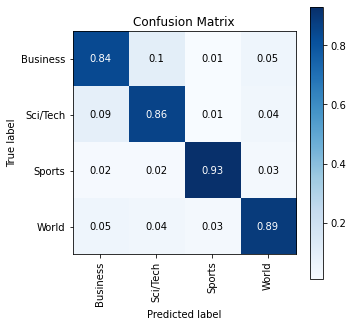

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [ ]:
# Q5. Try changing some hyper parameters to improve the model
# A5. I changed the max_word to 50, num_epoch to 30, and hidden_dim to 100.
# Some of classes showed better result while the new model didn't improve one class's accuracy.


In [ ]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 50

def collate_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] # Tokenize and map tokens to indexes
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 # Subtract 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=collate_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=collate_batch)


In [ ]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 100
n_layers=1

class LSTMClass2(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim).to(device)
        cell = torch.randn(n_layers, len(X_batch), hidden_dim).to(device)
        output, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
        return self.linear(output[:,-1]) # just want the last time step hidden state

In [ ]:
model = LSTMClass2()
model

LSTMClass2(
  (embedding_layer): Embedding(95811, 50)
  (lstm): LSTM(50, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
for layer in model.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(95811, 50)
Parameters : 
torch.Size([95811, 50])

Layer : LSTM(50, 100, batch_first=True)
Parameters : 
torch.Size([400, 50])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])

Layer : Linear(in_features=100, out_features=4, bias=True)
Parameters : 
torch.Size([4, 100])
torch.Size([4])



In [ ]:
from torch.optim import Adam

epochs = 30
learning_rate = 1e-3

# Q3. Put model on device before intialising the optimiser
model= model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:07<00:00, 14.79it/s]


Epoch	   : 1
Train Loss : 1.277
Valid Loss : 1.051
Valid Acc  : 0.518


100%|██████████| 118/118 [00:05<00:00, 20.80it/s]


Epoch	   : 2
Train Loss : 0.860
Valid Loss : 0.753
Valid Acc  : 0.708


100%|██████████| 118/118 [00:07<00:00, 16.18it/s]


Epoch	   : 3
Train Loss : 0.551
Valid Loss : 0.510
Valid Acc  : 0.821


100%|██████████| 118/118 [00:05<00:00, 20.86it/s]


Epoch	   : 4
Train Loss : 0.406
Valid Loss : 0.416
Valid Acc  : 0.857


100%|██████████| 118/118 [00:06<00:00, 18.34it/s]


Epoch	   : 5
Train Loss : 0.341
Valid Loss : 0.382
Valid Acc  : 0.868


100%|██████████| 118/118 [00:05<00:00, 19.79it/s]


Epoch	   : 6
Train Loss : 0.300
Valid Loss : 0.364
Valid Acc  : 0.877


100%|██████████| 118/118 [00:06<00:00, 18.19it/s]


Epoch	   : 7
Train Loss : 0.269
Valid Loss : 0.350
Valid Acc  : 0.881


100%|██████████| 118/118 [00:05<00:00, 20.55it/s]


Epoch	   : 8
Train Loss : 0.246
Valid Loss : 0.343
Valid Acc  : 0.886


100%|██████████| 118/118 [00:05<00:00, 20.76it/s]


Epoch	   : 9
Train Loss : 0.224
Valid Loss : 0.346
Valid Acc  : 0.889


100%|██████████| 118/118 [00:05<00:00, 20.90it/s]


Epoch	   : 10
Train Loss : 0.208
Valid Loss : 0.336
Valid Acc  : 0.891


100%|██████████| 118/118 [00:05<00:00, 21.18it/s]


Epoch	   : 11
Train Loss : 0.190
Valid Loss : 0.318
Valid Acc  : 0.895


100%|██████████| 118/118 [00:05<00:00, 20.66it/s]


Epoch	   : 12
Train Loss : 0.177
Valid Loss : 0.340
Valid Acc  : 0.891


100%|██████████| 118/118 [00:05<00:00, 20.93it/s]


Epoch	   : 13
Train Loss : 0.163
Valid Loss : 0.335
Valid Acc  : 0.897


100%|██████████| 118/118 [00:05<00:00, 20.90it/s]


Epoch	   : 14
Train Loss : 0.151
Valid Loss : 0.329
Valid Acc  : 0.897


100%|██████████| 118/118 [00:06<00:00, 19.34it/s]


Epoch	   : 15
Train Loss : 0.140
Valid Loss : 0.341
Valid Acc  : 0.894


100%|██████████| 118/118 [00:05<00:00, 19.89it/s]


Epoch	   : 16
Train Loss : 0.130
Valid Loss : 0.342
Valid Acc  : 0.897


100%|██████████| 118/118 [00:05<00:00, 20.57it/s]


Epoch	   : 17
Train Loss : 0.119
Valid Loss : 0.355
Valid Acc  : 0.897


100%|██████████| 118/118 [00:05<00:00, 20.55it/s]


Epoch	   : 18
Train Loss : 0.110
Valid Loss : 0.363
Valid Acc  : 0.896


100%|██████████| 118/118 [00:06<00:00, 18.70it/s]


Epoch	   : 19
Train Loss : 0.102
Valid Loss : 0.364
Valid Acc  : 0.895


100%|██████████| 118/118 [00:05<00:00, 20.22it/s]


Epoch	   : 20
Train Loss : 0.095
Valid Loss : 0.366
Valid Acc  : 0.896


100%|██████████| 118/118 [00:05<00:00, 20.71it/s]


Epoch	   : 21
Train Loss : 0.090
Valid Loss : 0.413
Valid Acc  : 0.889


100%|██████████| 118/118 [00:05<00:00, 20.50it/s]


Epoch	   : 22
Train Loss : 0.081
Valid Loss : 0.417
Valid Acc  : 0.891


100%|██████████| 118/118 [00:05<00:00, 20.75it/s]


Epoch	   : 23
Train Loss : 0.075
Valid Loss : 0.413
Valid Acc  : 0.895


100%|██████████| 118/118 [00:05<00:00, 20.53it/s]


Epoch	   : 24
Train Loss : 0.068
Valid Loss : 0.424
Valid Acc  : 0.894


100%|██████████| 118/118 [00:05<00:00, 20.72it/s]


Epoch	   : 25
Train Loss : 0.066
Valid Loss : 0.454
Valid Acc  : 0.897


100%|██████████| 118/118 [00:05<00:00, 20.75it/s]


Epoch	   : 26
Train Loss : 0.059
Valid Loss : 0.447
Valid Acc  : 0.890


100%|██████████| 118/118 [00:05<00:00, 20.39it/s]


Epoch	   : 27
Train Loss : 0.058
Valid Loss : 0.439
Valid Acc  : 0.893


100%|██████████| 118/118 [00:05<00:00, 20.52it/s]


Epoch	   : 28
Train Loss : 0.051
Valid Loss : 0.477
Valid Acc  : 0.892


100%|██████████| 118/118 [00:05<00:00, 20.86it/s]


Epoch	   : 29
Train Loss : 0.047
Valid Loss : 0.473
Valid Acc  : 0.892


100%|██████████| 118/118 [00:05<00:00, 20.50it/s]


Epoch	   : 30
Train Loss : 0.046
Valid Loss : 0.466
Valid Acc  : 0.893


In [ ]:
def MakePredictions(model, loader):
    Y_real, Y_preds = [], []
    for X, Y in loader:
        # Q4. Make sure that data are on the GPU
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_real.append(Y)
    gc.collect()
    Y_preds, Y_real = torch.cat(Y_preds), torch.cat(Y_real)

    return Y_real.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

Y_actual, Y_preds = MakePredictions(model, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Test Accuracy : {accuracy_score(Y_actual, Y_preds)}")
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8921052631578947

Classification Report : 
              precision    recall  f1-score   support

       World       0.88      0.91      0.90      1900
      Sports       0.96      0.94      0.95      1900
    Business       0.89      0.82      0.85      1900
    Sci/Tech       0.84      0.89      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1728   42   64   66]
 [  56 1793   22   29]
 [  98   19 1562  221]
 [  73   23  107 1697]]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


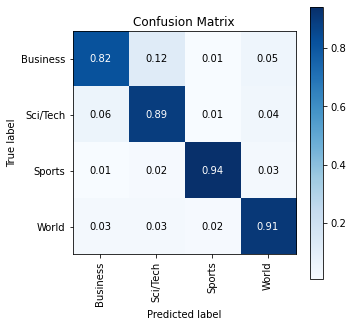

In [ ]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);